In [1]:
import sys
sys.path.append("/home/ly/workspace/mmsa")
seed = 1445
import numpy as np
import torch
from torch import nn
from torch import optim

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
from models.bigru_rcnn import *
from utils.train import *
from typing import *
from collections import Counter
from utils.load_yelp import *
from utils.dataset import *
from utils.train import *

In [2]:
config

{'task': 'CLS',
 'embedding_dim': 100,
 'embedding': None,
 'freeze_embedding': False,
 'text_hidden_size': 100,
 'text_layers': 1,
 'bias_init': 1.0,
 'img_input_size': 2048,
 'bbox_head': 4,
 'img_output_size': 100,
 'img_head': 4,
 'img_num': 3,
 'output_size': 5,
 'uniform_bound': 0.1,
 'dropout': 0.5}

In [3]:
train_set, valid_set, test_set= load_glove_data(config)

In [4]:
%%time
batch_size = 128
workers = 8
train_loader, valid_loader, test_loader = get_loader(batch_size, workers, get_collate_fn(config), train_set, valid_set, test_set)

CPU times: user 67 µs, sys: 8 µs, total: 75 µs
Wall time: 77.2 µs


In [5]:
model = Model(config).cuda()
loss = nn.CrossEntropyLoss()
get_parameter_number(model), loss

/home/ly/miniconda3/envs/torch1.6.0/lib/python3.7/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


({'Total': 21438961, 'Trainable': 21438961}, CrossEntropyLoss())

In [7]:
# viz = get_Visdom()
# lr = 1e-3
# epoches = 20
# optimizer = get_regal_optimizer(model, optim.AdamW, lr)
# k_batch_train_visdom(model, optimizer, loss, valid_loader, viz, 30, 5)

Setting up a new session...
100%|██████████| 30/30 [00:25<00:00,  1.18it/s]


In [6]:
%%time
y_true, y_pred, _loss = predict(model, valid_loader, loss)
evalute(y_true, y_pred), Counter(y_pred)

CPU times: user 3.25 s, sys: 1.19 s, total: 4.44 s
Wall time: 6.61 s


((0.2036117381489842, 0.11381352109624095),
 Counter({2: 3261, 0: 1142, 4: 16, 3: 9, 1: 2}))

In [7]:
viz = get_Visdom()
_interval = 5
batch_loss_drawer = VisdomScalar(viz, f"batch_loss interval:{_interval}")
epoch_loss_drawer = VisdomScalar(viz, f"Train and valid loss", 2)
acc_drawer = VisdomScalar(viz, "Train and valid accuracy", 2)

batch_loss = []
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []


Setting up a new session...


In [8]:
%%time
lr = 1e-3
epoches = 20
optimizer = get_regal_optimizer(model, optim.AdamW, lr)
res, model = train_visdom(model, optimizer, loss, viz, train_loader,
                          valid_loader, epoches, batch_loss, batch_loss_drawer,
                          train_loss, valid_loss, epoch_loss_drawer,
                          train_acc, valid_acc, acc_drawer,
                         _interval=_interval)

No 1 epoch:: 277it [01:00,  4.54it/s]


No 1 epoch: train_loss:1.4710068736767161 train_acc:0.3163210607984201 valid_loss:1.2291231792613562 valid_acc:0.4873589164785553


No 2 epoch:: 277it [01:00,  4.61it/s]


No 2 epoch: train_loss:1.2659678373472667 train_acc:0.4134856820426012 valid_loss:1.0398510666517855 valid_acc:0.5846501128668171


No 3 epoch:: 277it [01:00,  4.60it/s]


No 3 epoch: train_loss:1.1981173660980828 train_acc:0.44054168429961915 valid_loss:0.9977690441613811 valid_acc:0.5855530474040632


No 4 epoch:: 277it [01:00,  4.55it/s]


No 4 epoch: train_loss:1.1405179462911783 train_acc:0.4643814360276485 valid_loss:0.9494156523698071 valid_acc:0.5968397291196388


No 5 epoch:: 277it [01:01,  4.54it/s]


No 5 epoch: train_loss:1.086016829038376 train_acc:0.4889829313020172 valid_loss:0.9441208863096905 valid_acc:0.5961625282167042


No 6 epoch:: 277it [01:01,  4.52it/s]


No 6 epoch: train_loss:1.0236704566882653 train_acc:0.517618846099591 valid_loss:0.9826188147740762 valid_acc:0.5772009029345373


No 7 epoch:: 277it [01:00,  4.57it/s]


No 7 epoch: train_loss:0.9629789204199941 train_acc:0.5443080829454083 valid_loss:1.0143853923806219 valid_acc:0.5744920993227991


No 8 epoch:: 277it [01:00,  4.55it/s]


No 8 epoch: train_loss:0.9031068248495865 train_acc:0.5702073635209479 valid_loss:1.0668983550426923 valid_acc:0.555079006772009


No 9 epoch:: 277it [01:01,  4.53it/s]


No 9 epoch: train_loss:0.8445537772866765 train_acc:0.5934828607702074 valid_loss:1.1483302146532735 valid_acc:0.5512415349887133
CPU times: user 7min 47s, sys: 1min 55s, total: 9min 42s
Wall time: 10min 2s


In [9]:
res

{'max_acc': 0.5968397291196388,
 'max_acc_epoch': 4,
 'max_train_acc': 0.4643814360276485,
 'max_acc_train_loss': 1.1405179462911783,
 'max_acc_valid_loss': 0.9494156523698071,
 'last_acc': 0.5512415349887133,
 'last_train_acc': 0.5934828607702074,
 'last_epoch': 9,
 'last_train_loss': 0.8445537772866765,
 'last_valid_loss': 1.1483302146532735}

In [10]:
eval_model(model, test_loader, loss)

/home/ly/miniconda3/envs/torch1.6.0/lib/python3.7/site-packages/torch/nn/modules/rnn.py:738: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629427478/work/aten/src/ATen/native/cudnn/RNN.cpp:1234.)
  self.num_layers, self.dropout, self.training, self.bidirectional)


((0.5844243792325057, 0.5770253907919218), 0.9534272832203127)

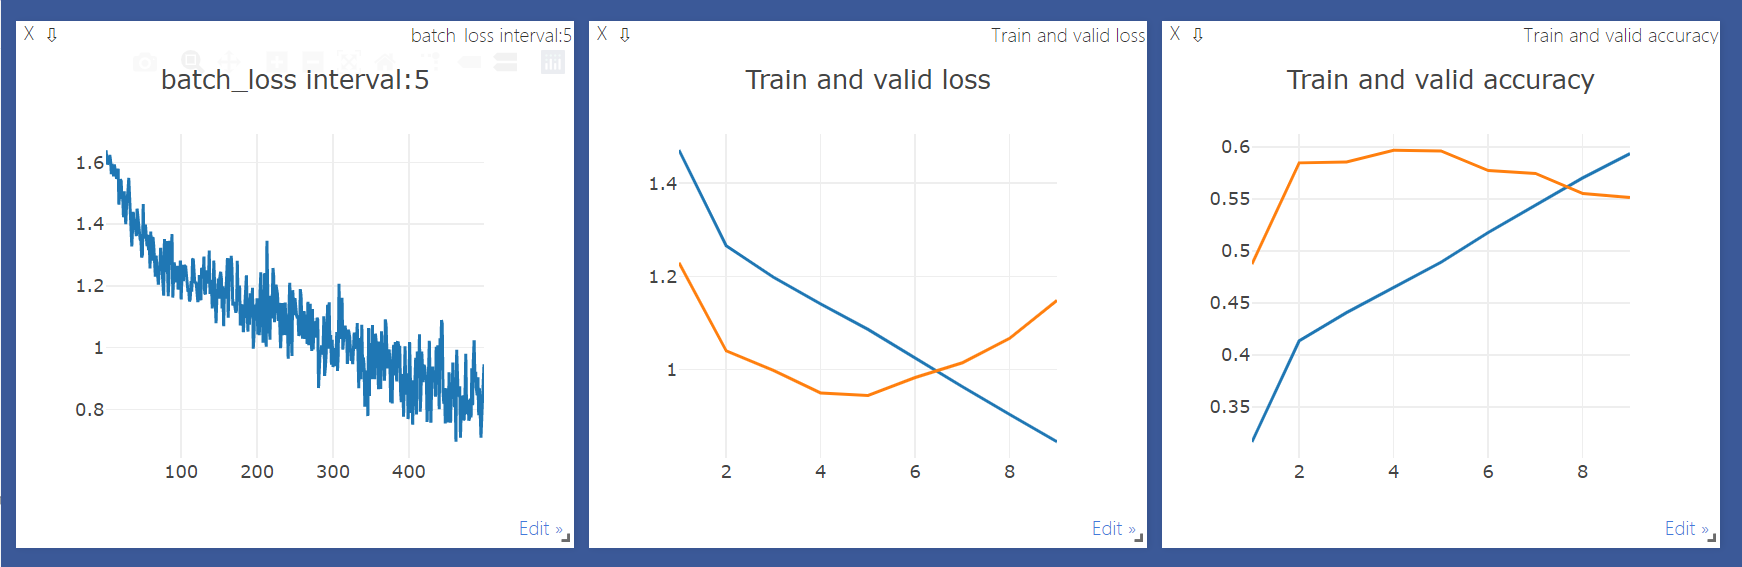